# WFlow Model Setup for Catchment FR000119

This notebook initializes and runs the **WFlow** model using **eWaterCycle**, ERA5 forcing, and compares the simulated discharge with observed data for catchment FR000119.

## Importing Python modules

In [75]:
%matplotlib inline
# General python
import numpy as np
from pathlib import Path
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr
import logging
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
logging.basicConfig(level=logging.WARN)

# Niceties
from rich import print
from tqdm import tqdm


# General eWaterCycle
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing
from ewatercycle.forcing import sources
import ewatercycle.parameter_sets
from ewatercycle.models import Wflow

## Choose region and time period

In [60]:
# name of the catchment
basin_name = "FR000119"

# Define time period and shapefile
wflow_experiment_start_date = "2013-11-26T00:00:00Z"
wflow_experiment_end_date = "2019-12-31T00:00:00Z"
# Set paths and parameters
shapefile_path = Path.home() / "BEP-Elke" / "book" / "thesis_projects" / "BSc" / "2025_Q4_ElkeSchokking_CEG" / "work in progress" / "ShapefilesFR000119" / "FR000119.shp"
dem_file_path = Path("wflow_dem.map")

In [61]:
# Location forcing files in home directory
wflow_forcing_path = Path.home() / "forcing" / "FR000119" / "WFlow_ERA5"
wflow_forcing_path.mkdir(parents=True, exist_ok=True)

## Generate ERA 5 Forcing, specifically for WFlow

In [62]:
# #Checking for DEM file
# from pathlib import Path
# import os

# # Example: look in your thesis project directory for DEM files
# dem_root = Path.home() / "BEP-Elke" / "book" / "thesis_projects"
# for root, dirs, files in os.walk(dem_root):
#     for f in files:
#         if f.endswith(".tif"):
#             print(Path(root) / f)

In [66]:
# Generate the forcing
wflow_forcing = sources["WflowForcing"].generate(
    dataset="ERA5",
    start_time="2013-11-26T00:00:00Z",
    end_time="2019-12-31T00:00:00Z",
    shape=shapefile_path,
    dem_file=str(dem_file_path.absolute())  # <- convert Path to string
)

# --- Load existing WFlow forcing
#wflow_forcing_dir = Path("/home/elke/BEP-Elke/book/thesis_projects/BSc/2025_Q4_ElkeSchokking_CEG/work in progress/esmvaltool_output/ewcrep5yvtlv4f_20250525_104347/work/diagnostic/script")
#wflow_forcing = sources["WflowForcing"].load(directory=wflow_forcing_dir)

In [67]:
print(wflow_forcing)

WflowForcing(
    start_time='2013-11-26T00:00:00Z',
    end_time='2019-12-31T00:00:00Z',
    directory=PosixPath('/home/elke/BEP-Elke/book/thesis_projects/BSc/2025_Q4_ElkeSchokking_CEG/work in 
progress/esmvaltool_output/ewcrep921cf36o_20250529_151839/work/diagnostic/script'),
    shape=PosixPath('/home/elke/BEP-Elke/book/thesis_projects/BSc/2025_Q4_ElkeSchokking_CEG/work in 
progress/ShapefilesFR000119/FR000119.shp'),
    filenames={},
    netcdfinput='wflow_ERA5_FR000119_2013_2019.nc',
    Precipitation='/pr',
    EvapoTranspiration='/pet',
    Temperature='/tas',
    Inflow=None
)

<xarray.Dataset> Size: 969MB
Dimensions:    (time: 2556, lat: 169, lon: 187, bnds: 2)
Coordinates:
  * time       (time) datetime64[ns] 20kB 2013-01-01T12:00:00 ... 2019-12-31T...
  * lat        (lat) float64 1kB 52.05 52.02 51.98 51.94 ... 45.97 45.93 45.89
  * lon        (lon) float64 1kB 5.227 5.264 5.3 5.337 ... 11.97 12.01 12.05
    height     float64 8B 2.0
Dimensions without coordinates: bnds
Data variables:
    pr         (time, lat, lon) float32 323MB 8.07 8.07 8.07 ... 0.0 0.0 0.0
    time_bnds  (time, bnds) datetime64[ns] 41kB 2013-01-01 ... 2020-01-01
    lat_bnds   (lat, bnds) float64 3kB 52.07 52.04 52.04 ... 45.91 45.91 45.88
    lon_bnds   (lon, bnds) float64 3kB 5.209 5.245 5.245 ... 12.03 12.03 12.07
    tas        (time, lat, lon) float32 323MB 6.961 6.94 6.902 ... 3.237 4.01
    pet        (time, lat, lon) float32 323MB 0.4312 0.4313 ... 0.494 0.4887
Attributes:
    Conventions:  CF-1.7
    software:     Created with ESMValTool v2.11.1
    caption:      Forcings for the wflow hydrological model.

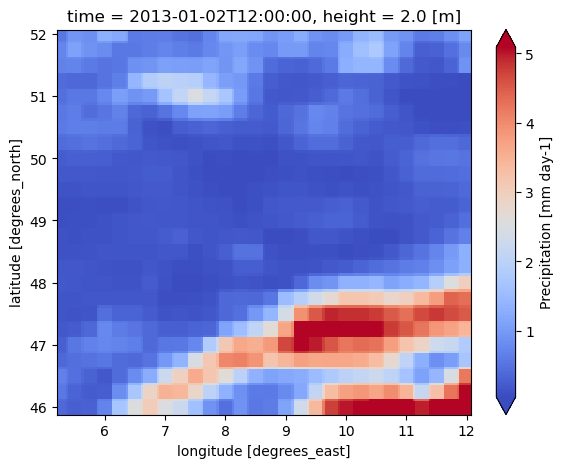

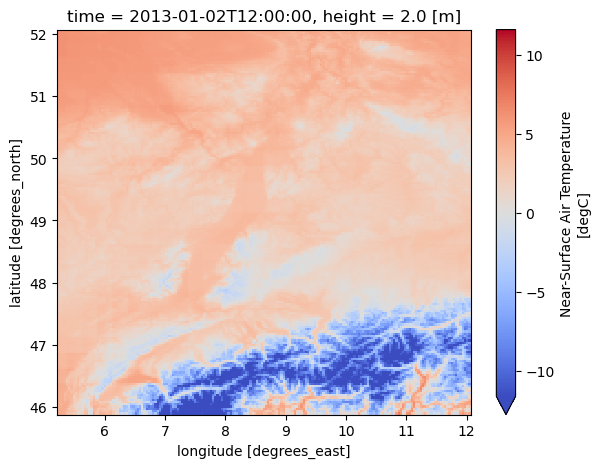

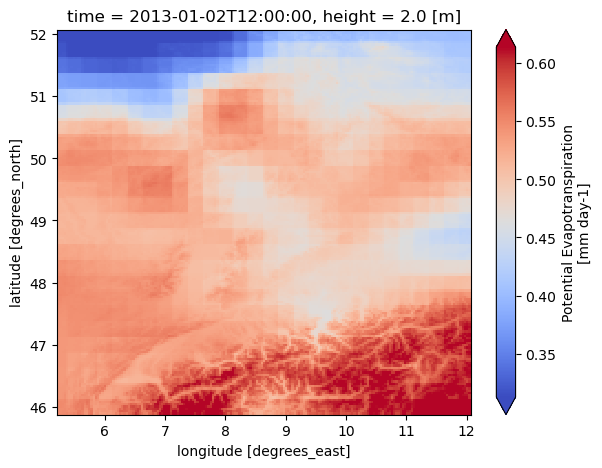

In [68]:
#Plot forcing data
dataset = xr.load_dataset(f"{wflow_forcing.directory}/{wflow_forcing.netcdfinput}")
print(dataset)
for var in ["pr", "tas", "pet"]:
    dataset[var].isel(time=1).plot(cmap="coolwarm", robust=True, size=5)

## Defining historical data from eStreams
The original CSV file had some formatting and encoding issues—like strange quotation marks and all the data crammed into a single column—which made it impossible to load with the usual pandas.read_csv() method. To work around this, I used a custom parser to manually extract the dates and discharge values.

In [34]:
# Manually parse the file
dates = []
discharges = []

with open("A3550050.csv", "r", encoding="utf-8") as f:
    next(f)
    for line in f:
        parts = line.replace('""', '"').strip().split(',"')
        if len(parts) >= 2:
            date_str = parts[0].strip('"')
            discharge_str = parts[1].strip('"')
            try:
                dates.append(pd.to_datetime(date_str))
                discharges.append(float(discharge_str))
            except ValueError:
                continue

discharge_series = pd.Series(discharges, index=dates, name="Discharge (m³/s)")
Q_obs = discharge_series[experiment_start_date:experiment_end_date]

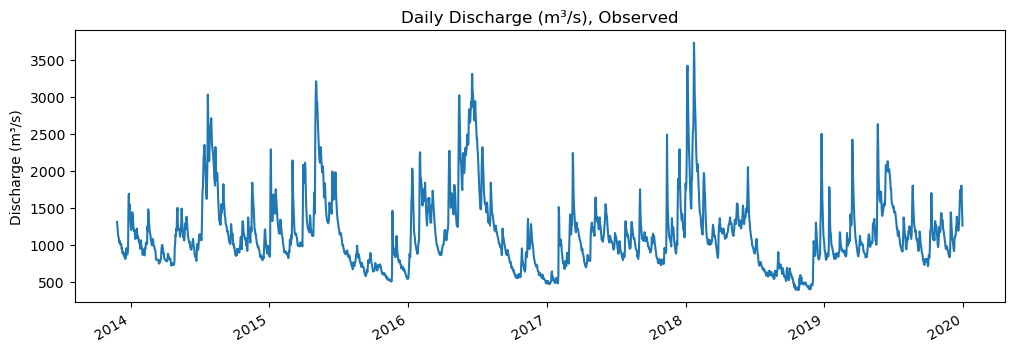

In [35]:
# Plot
Q_obs.plot(figsize=(12,4), title="Daily Discharge (m³/s), Observed")
plt.ylabel("Discharge (m³/s)")
plt.show()

## Initialize and run WFlow model using defined dates and forcing

In [70]:
# # Load WFlow parameter set
# # Use one of the available parameter sets
# available_sets = ewatercycle.parameter_sets.available_parameter_sets()
# print(available_sets)

In [45]:
# I choose: 'wflow_Rhine_ERA5-calibrated'. Because it is explicitly listed as calibrated for the Rhine using ERA5 forcing, matching my current forcing source. It uses the wflow_sbm_era5.ini config file, which is appropriate for WFlow setups.

# Load parameter set
wflow_parameter_set = available_sets["wflow_Rhine_ERA5-calibrated"]

## Setting up the model
The model needs a parameter set and forcing. The parameter set can be gotten from the available parameters sets on the system and the forcing can derived from the parameter set.

In [71]:
# Create WFlow model
wflow_model = Wflow(
    forcing=wflow_forcing,
    parameter_set=wflow_parameter_set,
    start_time=wflow_experiment_start_date,
    end_time=wflow_experiment_end_date
)

In [74]:
cfg_file, cfg_dir = wflow_model.setup()
print("CFG File:", cfg_file)

wflow_model.initialize(cfg_file)
wflow_model.run()
wflow_model.finalize()

CFG File: /home/elke/BEP-Elke/book/thesis_projects/BSc/2025_Q4_ElkeSchokking_CEG/work in 
progress/wflow_20250530_113109/wflow_ewatercycle.ini

_InactiveRpcError: <_InactiveRpcError of RPC that terminated with:
	status = StatusCode.UNKNOWN
	details = "Exception calling application: X coordinates in netcdf do not match model"
	debug_error_string = "UNKNOWN:Error received from peer  {grpc_message:"Exception calling application: X coordinates in netcdf do not match model", grpc_status:2, created_time:"2025-05-30T13:31:31.998897156+02:00"}"
>